# uvfmeas of secondary

I'm interested in how consistent or variable the uvfmeas spectrum of the secondary calibrator is. 

I hope to assess how much it changes across time and between bands. It might make sense to fit some type of model to use in `gpcal` for use as a flux calibrator. Although this is not completely necessary, since I plan on using both IFs together it would be important to ensure a consistent calibration. 

It looks like in semester two where the `tvmedian` option was used that the spectrum is a lot nice across both bands. The semester one data not so much. 

In [1]:
% matplotlib inline
import pandas as pd
import glob
import matplotlib.pyplot as plt

In [19]:
def uvfmeas_logs(freq):
    files = glob.glob(f'../Data/*/Plots/secondary_uvfmeas_{freq}_log.txt')
    dfs = []

    for f in files:
        print(f"Loading {f}")
        date = f.split('/')[2]
        print(f"\t{date}")
        df = pd.read_csv(f, names=('nu','s_nu','s_model'), delim_whitespace=True)
        df['date'] = date

        dfs.append(df)

    return pd.concat(dfs)

df_7 = uvfmeas_logs('7700')
df_9 = uvfmeas_logs('9500')

Loading ../Data/2017-12-18/Plots/secondary_uvfmeas_7700_log.txt
	2017-12-18
Loading ../Data/2017-12-16/Plots/secondary_uvfmeas_7700_log.txt
	2017-12-16
Loading ../Data/2017-12-17/Plots/secondary_uvfmeas_7700_log.txt
	2017-12-17
Loading ../Data/2018-06-23/Plots/secondary_uvfmeas_7700_log.txt
	2018-06-23
Loading ../Data/2018-06-07/Plots/secondary_uvfmeas_7700_log.txt
	2018-06-07
Loading ../Data/2018-01-10/Plots/secondary_uvfmeas_7700_log.txt
	2018-01-10
Loading ../Data/2018-06-08/Plots/secondary_uvfmeas_7700_log.txt
	2018-06-08
Loading ../Data/2018-06-30/Plots/secondary_uvfmeas_7700_log.txt
	2018-06-30
Loading ../Data/2018-06-06/Plots/secondary_uvfmeas_7700_log.txt
	2018-06-06
Loading ../Data/2018-06-01/Plots/secondary_uvfmeas_7700_log.txt
	2018-06-01
Loading ../Data/2017-11-24/Plots/secondary_uvfmeas_7700_log.txt
	2017-11-24
Loading ../Data/2017-11-23/Plots/secondary_uvfmeas_7700_log.txt
	2017-11-23
Loading ../Data/2018-07-01/Plots/secondary_uvfmeas_7700_log.txt
	2018-07-01
Loading ../D

/Users/gal16b/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


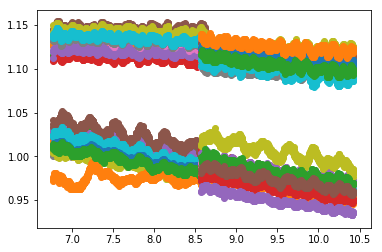

In [22]:
fig, ax = plt.subplots(1,1)

for index, sub in df_7.groupby('date'):
    ax.scatter(sub['nu'], sub['s_nu'])

for index, sub in df_9.groupby('date'):
    ax.scatter(sub['nu'], sub['s_nu'])

fig.show()